### MNIST
    -DESCR key describing the dataset.
    -A data containing the array with one row per instance and one column per feature.
    -A target key containing an array with the labels.


In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X,y = mnist['data'], mnist['target']
print('X: ',X.shape)
print('y: ',y.shape)

X:  (70000, 784)
y:  (70000,)


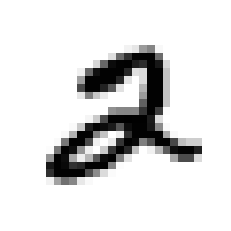

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit = X[5]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [4]:
y[5]

'2'

In [5]:
y = y.astype(np.uint8)

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:],y[:60000], y[60000:]

### Binary Classifier
    -Capable of distinguish between just two classes.
 

In [7]:
y_train_2 = (y_train == 2)
y_test_2 = (y_test == 2)

### Stochastic Gradient Descent (SGD) Classifier
    -Sklearn SGDClassifier
    -Capable of handling very large dataset efficiently.
    -Suitable for online learning.

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_2)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

### Peformance Measures

### 1. Measuring Accuracy Using Cross-Validation
    -K-Fold cross-validation

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_2, cv=3, scoring='accuracy')

array([0.96645, 0.95895, 0.904  ])

Creating the never 2 classifier just to check whether our cross val result match with this classifier

In [11]:
from sklearn.base import BaseEstimator

class never2Classifier(BaseEstimator):
    def fit(self, X,y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [12]:
never2class = never2Classifier()
cross_val_score(never2class, X_train,y_train_2,
                cv=3, scoring='accuracy')

array([0.90355, 0.8993 , 0.89925])

*It has 90% accuracy because only 10% images are labelled 2.*

### Confusion Matrix
    - To evaluate performance of a classifier.
    
    - General idea is to count how much times the instances are classified wrongly.
    

### Cross_val_predict
    - Performs K-Fold cross validation.
    - Returns predictions made on each test fold.

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train,
                                y_train_2, cv=3)

### Confusion Matrix
    - [1,1] = true negative
    - [1,2] = false positives
    - [2,1] = false negatives
    - [2,2] = true positives
    
    - Perfect classifier only possess true positives and true negatives.
    
    - precison = accuracy of the positive predictors.
    
    - recall/sensitivity/true_positive_rate = ratio of positive instances that are correctly detected by the classifier.

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_2, y_train_pred)

array([[51538,  2504],
       [  908,  5050]])

In [15]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_2, y_train_pred))
print(recall_score(y_train_2, y_train_pred))

0.6685199894095843
0.8475998657267539


### F1 Score
    - Combination of recall and precision.
    
    - Harmonic mean of precision and recall i.e gives much more weight to low values.
    
    - Classifier will only get high **f1** if both recall and precision are high.
    
    - In some context you mostly care about precision and in other case you really care about recall.

In [16]:
from sklearn.metrics import f1_score

f1_score(y_train_2, y_train_pred)

0.7474837181764358

### Precision/ Recall Trade-off
    - Classifier computes score based on decision function(threshold).
    - Lowering the threshold increses recall and reduces precision.

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([4616.86417714])

In [18]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

### The SGD classifier used threshold 0 in previous unit.

In [19]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold) 
y_some_digit_pred

array([False])

### Rising the threshold decreases recall


### Using cross_val_predict() to get all scores of all instances in the training set. It returns the scores than predictions.

In [20]:
y_scores = cross_val_predict(sgd_clf, 
                             X_train, y_train_2, cv=3,
                            method='decision_function')

### Precision Recall Curve

In [21]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_2, y_scores)

In [22]:
def plot_precision_recall_vs_threshold(precisions, recalls,
                                      thresholds):
    plt.plot(thresholds,precisions[:-1], 'b--',label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.grid()
    plt.legend()
    plt.xlabel('THreshold')
    
    

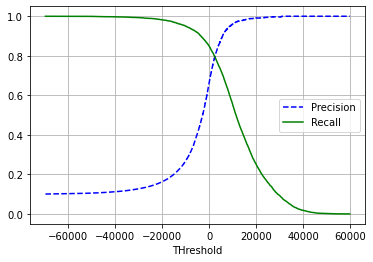

In [23]:
plot_precision_recall_vs_threshold(precisions,recalls,
                                  thresholds)
plt.show()

To be more precise you can search for the lowest that gives the 90% precision.

In [24]:
threshold_90_precision = thresholds[
    np.argmax(precisions >= 0.90)]

y_train_pred_90 = (y_scores >= threshold_90_precision)



In [25]:
precision_score(y_train_2, y_train_pred_90)

0.9000641985876311

In [26]:
recall_score(y_train_2, y_train_pred_90)

0.7059415911379657

 High precision classifier is not useful if it has low recall too.

### ROC Curve (Reciever Operating Characteristics)
    - Plots TPR v/s FPR

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_2, y_scores)

In [28]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') #dashed diagonal
    plt.grid()
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()

No handles with labels found to put in legend.


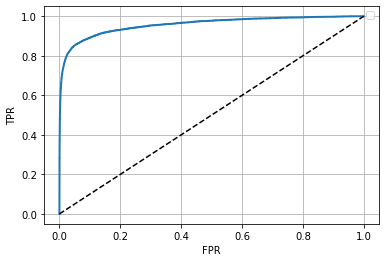

In [29]:
plot_roc_curve(fpr,tpr)
plt.show()

### AUC ROC

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_2, y_scores)

0.9568395257681235

### Random State Classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,
                            X_train, y_train_2, cv=3,
                            method='predict_proba')

In [32]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest= roc_curve(y_train_2,
                                                     y_scores_forest)

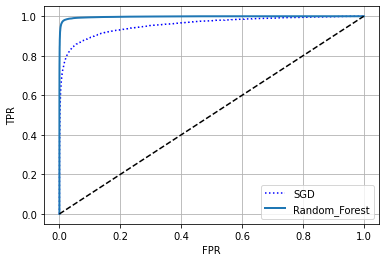

In [33]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest,tpr_forest,'Random_Forest')
plt.legend(loc='lower right')
plt.show()

In [34]:
roc_auc_score(y_train_2, y_scores_forest)

0.9976087190102003

In [35]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_2, y_scores_forest)

In [36]:
threshold_90_precision_forest = thresholds_forest[
    np.argmax(precisions_forest > 0.99)]

y_train_pred_90_forest = (y_scores_forest >= threshold_90_precision_forest)


In [37]:
print('Precision',precision_score(y_train_2, y_train_pred_90_forest))

Precision 0.9900448955690025


In [38]:
print('Recall',recall_score(y_train_2, y_train_pred_90_forest))

Recall 0.8512923799932863


### Multiclass Classification
    - OneVsAll (OvR)
    - OneVsOne (OvO)
    - Binary Classifier:
        - Logistic Regression
        - Support Vector Machine
            -OvO
    - Sklearn auto choose OvO/OvR

In [39]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([2], dtype=uint8)

In [40]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.7442516 , -0.30125634,  9.31399134,  7.26965016,  3.75753908,
         3.74771902,  0.71155138,  2.76650678,  8.2765048 ,  6.21840456]])

In [41]:
np.argmax(some_digit_scores)

2

In [42]:
svm_clf_clf_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [43]:
svm_clf.classes_[5]

5

### OvR Classifier

In [44]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)

OneVsRestClassifier(estimator=SVC())

In [45]:
ovr_clf.predict([some_digit])

array([2], dtype=uint8)

In [47]:
len(ovr_clf.estimators_)

10

### SGD Classifier
    -Decision function just returns one value per class.

In [48]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([2], dtype=uint8)

In [49]:
sgd_clf.decision_function([some_digit])

array([[-15541.82888672, -29286.65271153,   3512.16981303,
         -6832.08390768, -19312.77223333,  -9222.09311121,
        -33451.06615947, -21325.87368895,  -2296.78795949,
         -6958.23332214]])

Evaluating SGD accuracy using Cross Val

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train,
               cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

### Error Analysis

In [52]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled,
                                y_train, cv=3)

In [53]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

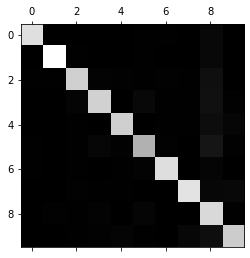

In [55]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [57]:
row_sums = conf_mx.sum(axis=1, keepdims= True)
norm_conf_mx = conf_mx / row_sums

Filling the diagonal with the zeros to keep only the errors, and plot the result.

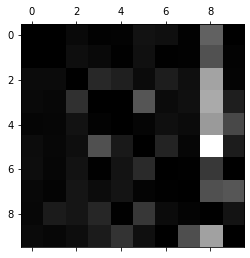

In [58]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap= plt.cm.gray)
plt.show()